In this notebook, we will learn about Markov Chain Monte Carlo (MCMC), which is a Bayesian sampling method.
We will also discuss other analysis we need to do following the sampling, which includes:
* estimating burn-in time,
* estimating the autocorrelation length,
* assessing convergence.

Recall that we will use the following notations:
* $y \in \mathbb{R}^M$ are the observed data,
* $f(\theta; t)$ is the parameterized model,
* $\theta \in \mathbb{R}^N$ are the parameters of the model,
* $t$ are the independent variables corresponding to the data,
* $M$ and $N$ are the number of data points (and model output) and parameters, respectively.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from model import FractionalModel
import scipy.optimize as scopt

%matplotlib inline
plt.style.use("default")
np.random.seed(1717)

We start with setting up the model.

In [2]:
# Define the model
t = np.array([0.1, 1.0, 1.1])
data = np.array([10.0, 0.7, 0.7])
data_error = 0.1 * data


def transform(theta):
    """Parameter transformation function phi."""
    return np.exp(theta)


model = FractionalModel(N=2, t=t, data=data, data_error=data_error, transform=transform)

In [3]:
# Train the model
opt = scopt.least_squares(model.residual, np.zeros(model.N), method="lm")
bestfit = opt.x
print(opt)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 5.796e-03 -7.197e-01  8.986e-01]
           x: [-2.763e+00 -1.311e+00]
        cost: 0.6627336391269714
         jac: [[ 6.303e+00  2.692e+00]
               [ 5.076e-01  2.168e+00]
               [ 3.659e-01  1.719e+00]]
        grad: [ 9.116e-09 -1.049e-07]
  optimality: 1.0491659953720616e-07
 active_mask: [0 0]
        nfev: 24
        njev: None


In [4]:
# Generate data to plot the cost surface
params_list = np.linspace(-6, 2, 100)
P0, P1 = np.meshgrid(params_list, params_list)  # Parameter grid

COST = np.zeros_like(P0)
for ii in range(len(params_list)):
    for jj in range(len(params_list)):
        params = np.array([P0[ii, jj], P1[ii, jj]])
        COST[ii, jj] = model.cost(params)

# Introduction to MCMC

MCMC sampling is a Bayesian UQ method.
By Bayes' theorem, the distribution of the parameters given the data (or the posterior distribution of the parameters) is
\begin{equation}
    P(\theta | y) \propto \mathcal{L}(\theta | y) \times \pi(\theta),
\end{equation}
where $\pi(\theta)$ is the prior distribution of the parameters.
The prior encodes the information we have about the parameters in the past, before we observe the data.
The likelihood encodes what we learn about the parameters from the data.
Thus, Bayes' theorem can be thought of as updating what we know about the parameters after we observe the data.

The general steps in MCMC, via the Metropolis-Hasting algorithm, are:
1. Start from a random location in parameter space, call this $\theta_{\text{initial}}$.
2. Propose a point by applying some random perturbation to the initial position, call this point as $\theta_{\text{propose}}$.
3. Accept or reject the proposed points according to some probability:
\begin{equation}
    P_{\text{accept}} = \min \left( \frac{P(\theta_{\text{propose}} | y)}{P(\theta_{\text{initial}} | y)}, 1 \right).
\end{equation}
4. Repeat from 1, where now $\theta_{\text{\propose}}$ becomes $\theta_{\text{initial}}$ if the move is accepted, otherwise keeps $\theta_{\text{initial}}$.

For an illustration regarding these steps, see this [website](http://chi-feng.github.io/mcmc-demo/).

Unlike other sampling methods, the beauty of MCMC is that we don't need to know the normalization constant of the posterior.
However, in turn, there are other additional post-processing that we need to do after the sampling.
We will discuss the post-processing calculation later in this notebook.

In this section, we will learn how to run MCMC in Python.
We will use [`emcee`](https://emcee.readthedocs.io/en/stable/) package to perform multi-chain MCMC.
Note that there are other packages that are widely used to run MCMC, such as [`PyMC3`](https://www.pymc.io/projects/docs/en/v3/index.html), which will not be discussed here.

We will start by defining the probability functions.
Recall that $\mathcal{L}(\theta | y) \propto \exp(-C(\theta))$.
Then, we will set the prior distribution to be the standard multivariate normal distribution.
We will see that using this prior, the mean of the posterior is different than the MLE or best fit.

In [5]:
import emcee
from scipy.stats import multivariate_normal

In [6]:
def loglikelihood(theta):
    return -model.cost(theta)


def logprior(theta):
    return multivariate_normal(mean=np.zeros(ndim)).logpdf(theta)


def logposterior(theta):
    return loglikelihood(theta) + logprior(theta)

In [7]:
# Instantiate MCMC sampler
nwalkers = 2 * model.N  # Number of parallel chains to simulate
ndim = model.N  # Dimension of parameter space
# pool = mp.Pool(nwalkers)  # Multiprocessing pool for parallelization
sampler = emcee.EnsembleSampler(
    nwalkers=nwalkers,
    ndim=ndim,
    log_prob_fn=logposterior,
    # moves=emcee.moves.StretchMove(a=5.0),  # Adjust the moves
    # pool=pool,  # Multiprocessing
)
# Initial positions of the walkers
p0 = np.random.uniform(-5, 5, (nwalkers, ndim))
# Run MCMC
sampler.run_mcmc(p0, 10_000, progress=True)
chains = sampler.chain  # Retrieve the chains
# pool.close()
print("Acceptance fraction:", sampler.acceptance_fraction)

100%|███████████████████████████████████████████████████████████| 10000/10000 [00:16<00:00, 622.88it/s]

Acceptance fraction: [0.7155 0.7107 0.7063 0.7246]


Note: Some people might argue that the acceptance fractions that we get are too high.
There is an argument that the expected acceptance fraction for MCMC should be around 23%.
So, if the acceptance fraction is too high (too low), we need to adjust the MCMC move, e.g., increasing (decreasing) the step size.

# Post-processing

There are 3 things that we need to do before we can extract the independent samples of the posterior from MCMC.
1. Discard the first few steps as a burn-in period.
This step is necessary because we don't want the MCMC result to be dependent on where we start the simulation.
2. Estimate the autocorrelation length and thin the remaining chains.
From MCMC sampling, we want to get samples that are independent of each other.
However, from the algorithm, notice that the sample at step $(i+1)$ is actually not independent from the sample at step $i$.
However, after several steps, the walker will forget its initial position, i.e., the sample at step $(i+\tau)$ would be independent of the sample at step $i$, where $\tau$ is the autocorrelation length.
Thus, we should only take every $\tau$ points from the chains.
To learn more about autocorrelation length, see `emcee` [documentation](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/#computing-autocorrelation-times).
3. Finally, using the remaining chains, we need to assess whether the sampling has converged to a stationary distribution.
That is, if the MCMC samples give a faithful representation of the actual posterior.
The MCMC simulation should only be terminated when some convergence criteria are satisfied.

## Estimating burn-in or equilibration time

A way to estimate the burn-in is to look at the plot of the trace for each walker.

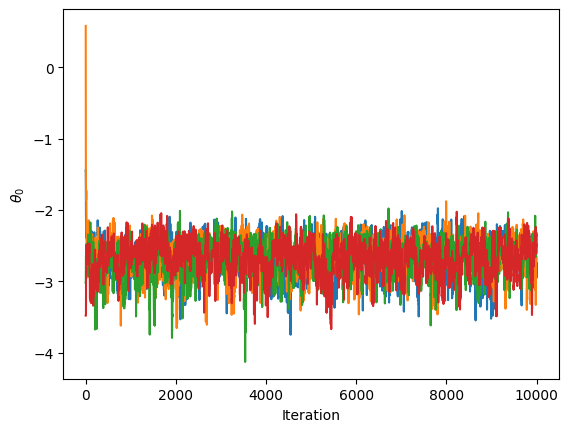

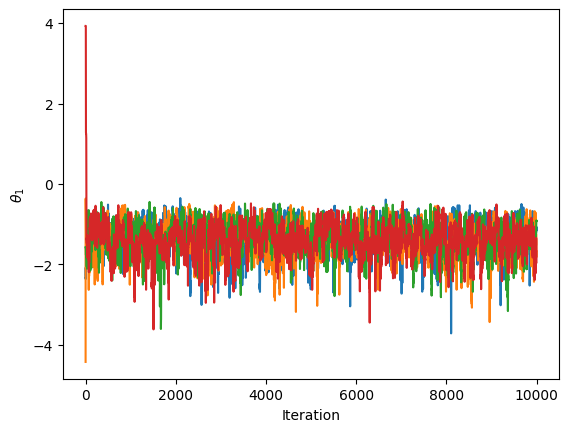

In [8]:
# Plot trace
for pidx in range(ndim):
    plt.figure()
    for widx in range(nwalkers):
        plt.plot(chains[widx, :, pidx])
    plt.xlabel("Iteration")
    plt.ylabel(f"$\\theta_{pidx}$")
plt.show()

From these figures, notice that the walkers initially start from different positions in parameter space.
However, after some time, they start to explore the same region in parameter space.
The burn-in period that needs to be discarded is the time before the walkers start to explore the same region of parameter space.

This way of estimating burn-in might be subjective.
However, there is a more rigorous way to do this.
For example, we will use the marginal standard error rule (MSER) to estimate the burn-in.
Let $\psi_k$ denotes the $k^{\text{th}}$ MCMC chain and $\psi_k(i, j)$ be the subset of the chain from step $i$ to step $j$.
We will also assume that we run MCMC simulation for $L$ steps.
Then, we discard the first $d$ steps from chain $k$ and compute the marginal standard error (MSE),
\begin{equation}
    \text{MSE}_k(d) = \frac{1}{L-d} \text{Var}\left(\psi_k(d, L)\right).
\end{equation}
The estimated equilibration time is
\begin{equation}
    \hat{d}_k = \underset{d}{\operatorname{arg min}} \text{MSE}_k(d).
\end{equation}

In [9]:
from mcmc_utils.equilibration import mser

In [10]:
# Estimate equilibration time via MSER
mser_list = np.zeros((nwalkers, ndim), dtype=int)
for widx in range(nwalkers):
    for pidx in range(ndim):
        mser_list[widx, pidx] = mser(chains[widx, :, pidx])
print(mser_list)
burnin = np.max(mser_list)
chains_noburnin = chains[:, burnin:]

[[ 30  20]
 [ 30  20]
 [ 10  10]
 [190  30]]


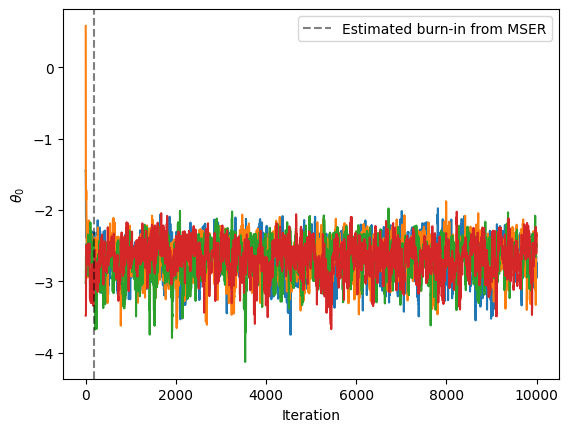

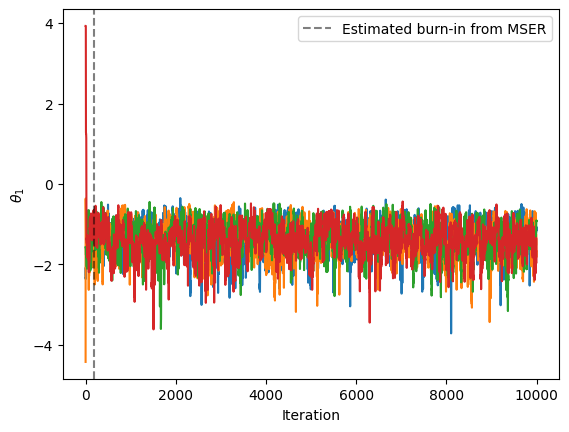

In [11]:
# Plot the trace
for pidx in range(ndim):
    plt.figure()
    for widx in range(nwalkers):
        plt.plot(chains[widx, :, pidx])
    plt.axvline(
        burnin, ls="--", color="k", alpha=0.5, label="Estimated burn-in from MSER"
    )
    plt.xlabel("Iteration")
    plt.ylabel(f"$\\theta_{pidx}$")
    plt.legend()
plt.show()

## Estimating autocorrelation length

Autocorrelation is defined as the correlation of a chain with a delayed copy of itself as a function of delay or lag.
The summary on the autocorrelation calculation can be found in `emcee` [documentation](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/#).
The plots of autocorrelation function for each parameter and walker are shown below.
The autocorrelation is denoted as $c_f(\tau)$, where $\tau$ is the delay or lag.

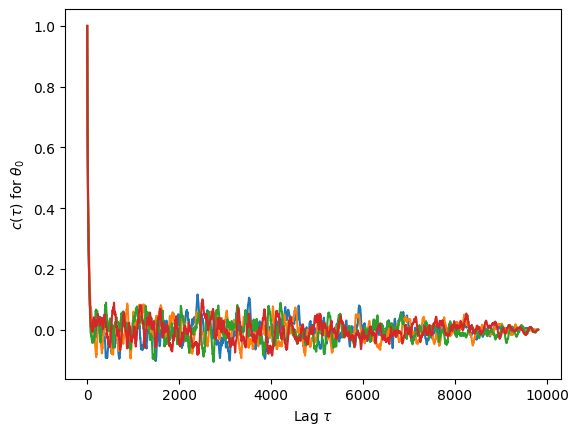

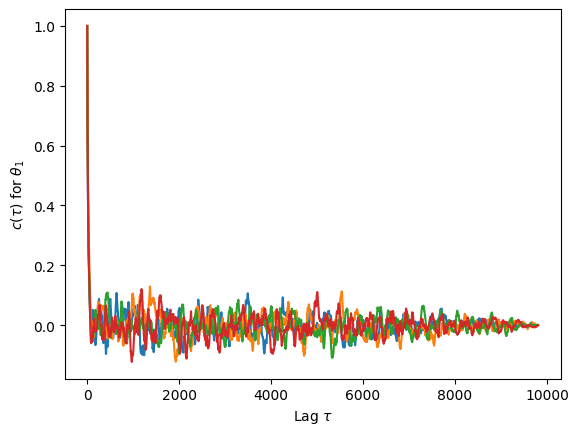

In [12]:
# Plot the autocorrelation function
for pidx in range(ndim):
    plt.figure()
    for widx in range(nwalkers):
        plt.plot(emcee.autocorr.function_1d(chains_noburnin[widx, :, pidx]))
    plt.xlabel(r"Lag $\tau$")
    plt.ylabel(f"$c(\\tau)$ for $\\theta_{pidx}$")
plt.show()

The `emcee` documentation also shows how to estimate the autocorrelation integrated time, which we will denote as $\hat{\tau}$.
The estimated number of steps that need to be taken before the walker forgets where it starts is given by $\hat{\tau}$.

Be aware that the function to estimate $\hat{\tau}$ assumes that the parameters are non-correlated.
Thus, the actual autocorrelation length would likely be larger than the estimated value, due to parameter correlation.
We can do some transformations to the chains to reduce the correlation between parameters.
This can be done by the following steps:
1. Shift the chains so that the mean coincides with the origin.
2. Compute the covariance matrix of the chains.
3. Compute the eigenvectors of the covariance matrix.
4. Use the orthogonal matrix of eigenvectors to rotate the chains. This operation reduces the average correlation between parameters.

Note: Even after performing this transformation, correlations between parameters are only guaranteed to be partially removed.
Especially when the parameters are correlated non-linearly.
Only in the case where we have a completely linear correlation between parameters, i.e., the posterior is a Gaussian, this transformation removes all correlations between parameters.

In [13]:
from mcmc_utils.autocorrelation import autocorr

In [14]:
# Estimate the autocorrelation length. We will also apply the transformation to
# decorrelate the parameters.
acorr = autocorr(chains_noburnin, decorrelate=True, quiet=True)
print(acorr)

thin = int(100 * (np.max(acorr) // 100 + 1))  # Round up to the nearest 100's
samples = chains_noburnin[:, ::thin]

[51.20135009 38.24807583]


## Assess convergence

Finally, after obtaining the independent samples, we need to assess if the samples have converged to a stationary distribution.
To do this, we will compute the potential scale reduction factor (PSRF), denoted by $\hat{R}^p$.
This quantity is calculated by
\begin{equation}
    \hat{R}^p = \frac{\tilde{L}-1}{\tilde{L}} + \frac{K+1}{K} \lambda_{\text{max}} (W^{-1}, B/l)
\end{equation}
where $\tilde{L}$ and K are the numbers of independent samples and chains, respectively, $\lambda_{\text{max}}(A)$ is the largest eigenvalue of matrix $A$,
\begin{equation}
    \left(\frac{B}{l}\right)_{k_1, k_2} = \text{Cov}(\bar{\psi}_{k_1}, \bar{\psi}_{k_2})
\end{equation}
is the covariance between the chains ($\bar{\psi}_k$ is the mean of chain $k$), and
\begin{equation}
    W = \frac{1}{K} \sum_{k=1}^K \text{Cov}(\psi_k)
\end{equation}
is the mean of the covariance within the chain.

As the number of independent samples approaches infinity, $\hat{R}^p$ declines to $1.0$.
Typically, we set a threshold and terminate the MCMC sampling when $\hat{R}^p$ falls below this threshold.
A common threshold value is $1.1$.

In [15]:
from mcmc_utils.convergence import rhat

In [16]:
# Check convergence
threshold = 1.1
rhat_value = rhat(samples)
print("Converged:", rhat_value < threshold)
print(rhat_value)

Converged: True
0.9966843183637197


# Presenting the result

In [17]:
samples_flatten = samples.reshape((-1, ndim))

First, we can look at the mean and standard deviation of the parameters from the MCMC samples

In [18]:
mcmc_mean = np.mean(samples_flatten, axis=0)
mcmc_std = np.std(samples_flatten, axis=0)

print("Mean:", mcmc_mean)
print("Standard deviation:", mcmc_std)

Mean: [-2.67896822 -1.37330887]
Standard deviation: [0.21704656 0.35543684]


Notice that the mean of the MCMC samples is shifted from the best fit parameters.
In a sense, the shifting is a consequence of the prior that we chose.
We can also see this when we plot the MCMC samples on top of the cost surface.
We see that the distribution of the samples is not really aligned with the cost surface.
However, this is not a problem, instead, this is a feature of a Bayesian method.

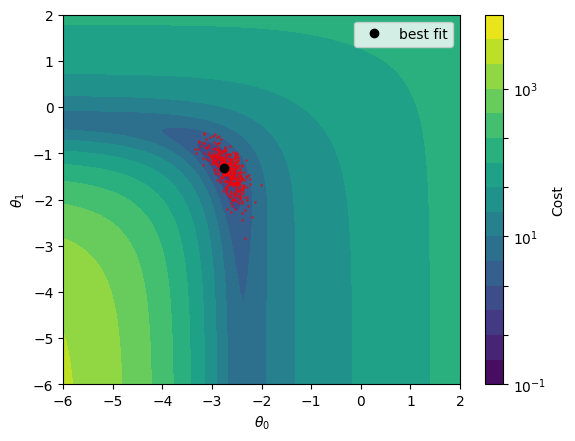

In [19]:
# Plot MCMC samples on the cost surface
plt.figure()
im = plt.contourf(
    P0, P1, COST, locator=mpl.ticker.LogLocator(), levels=np.logspace(-1, 4, 16)
)
clb = plt.colorbar(im)
plt.plot(*bestfit, "ko", label="best fit", zorder=10)

# Plot MCMC samples
plt.plot(*(samples_flatten.T), "r.", ms=2, alpha=0.5)

plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
clb.set_label("Cost")
plt.legend()
plt.show()

Another common way to present the MCMC samples is by using a corner plot.
A corner plot is an array of plots that look like a lower triangular matrix.
On the main diagonal, we plot the marginal distribution of each parameter.
Below the diagonal, we plot the 2-dimensional distribution of the parameters.

In [20]:
from corner import corner

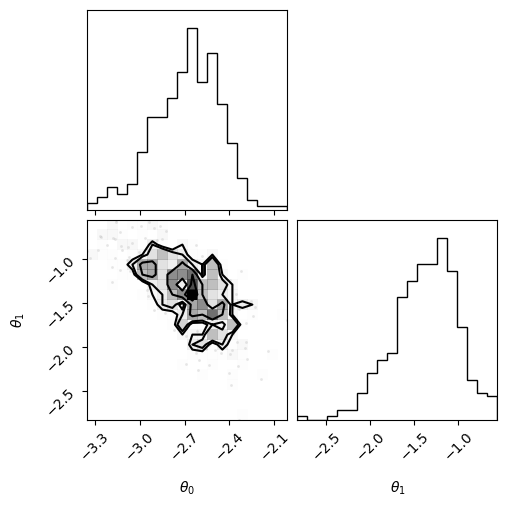

In [21]:
# Present the samples and the distribution as a corner plot.
corner(samples_flatten, labels=[r"$\theta_0$", r"$\theta_1$"])
plt.show()

Note: See the [documentation](https://corner.readthedocs.io/en/latest/) for the `corner` package to see other options that can be used, such as to turn off the 2-dimensional histogram on the plots below the diagonal. 

# Parallel tempering

Parallel tempering MCMC (PTMCMC) is another common variation of MCMC that is widely used to improve convergence.
The idea of PTMCMC is to introduce an artificial sampling temperature term in the posterior,
\begin{equation}
    P(\theta|y) \propto (\mathcal{L}(\theta)|y))^{1/T} \times \pi(\theta).
\end{equation}
Then, we run multiple MCMC simulations with different sampling temperatures in parallel.
Chains using different sampling temperatures are also swapped according to some probability.
By doing this, the MCMC chains are able to explore larger regions in parameter space.
Recently, this method is also used to account for an additional error term in the modeling due to model inadequacy.

To run PTMCMC, we will use `ptemcee` package.

Note: The original `ptemcee` repo hasn't been maintained for a long time.
There are some major issues that I have fixed in my fork of the repo.

In [22]:
import ptemcee
import multiprocessing as mp

In [23]:
# Instantiate MCMC sampler
betas = 1 / np.logspace(0, 2, 5)  # Generate a temperature ladder
ntemps = len(betas)
pool = mp.Pool(2)  # Multiprocessing pool for parallelization
ptsampler = ptemcee.Sampler(
    nwalkers=nwalkers,
    dim=ndim,
    betas=betas,
    logl=loglikelihood,
    logp=logprior,
    random=np.random.RandomState(1717),
    # a=5,  # Step size
    pool=pool,  # Multiprocessing
)
# Initial positions of the walkers
p0 = np.random.uniform(-5, 5, (ntemps, nwalkers, ndim))
# Run MCMC
ptsampler.run_mcmc(p0, 10_000, progress=True)
pool.close()
print("Acceptance fraction:", ptsampler.acceptance_fraction)

100%|███████████████████████████████████████████████████████████| 10000/10000 [01:28<00:00, 112.73it/s]

Acceptance fraction: [[0.7123 0.7117 0.7121 0.7021]
 [0.7896 0.7893 0.7856 0.7929]
 [0.7495 0.7483 0.7469 0.7512]
 [0.7672 0.758  0.7621 0.7645]
 [0.8399 0.8274 0.8341 0.8374]]


Note: Historically, parallel tempering is not really well accepted, since it increases computational cost significantly.
However, it was shown later that the improvement in the convergence outweigh the increase in the computational cost.
Especially that the MCMC simulation can be parallelized and there are many high performance computer available nowadays.

In [24]:
ptsamples = ptsampler.chain[:, :, 1000::100]

In [25]:
# Define colors to use on the samples.
colors = mpl.cm.get_cmap("inferno")(np.linspace(0, 1, ntemps))

/tmp/ipykernel_3297/3251760116.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = mpl.cm.get_cmap("inferno")(np.linspace(0, 1, ntemps))


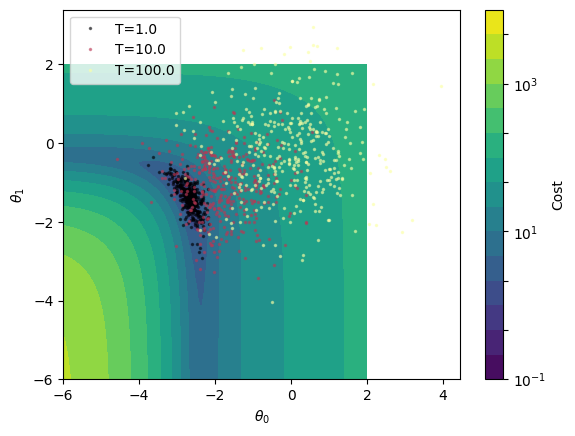

In [26]:
# Plot the MCMC samples on the cost surface
plt.figure()
im = plt.contourf(
    P0, P1, COST, locator=mpl.ticker.LogLocator(), levels=np.logspace(-1, 4, 16)
)
clb = plt.colorbar(im)

# Plot PTMCMC samples
for tidx in [0, 2, 4]:
    ptsamples_flatten = ptsamples[tidx].reshape((-1, ndim))
    plt.plot(
        *(ptsamples_flatten.T),
        ".",
        ms=3,
        alpha=0.5,
        color=colors[tidx],
        label=f"T={1/betas[tidx]}",
    )

plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
clb.set_label("Cost")
plt.legend()
plt.show()

As the sampling temperature increases, the likelihood becomes flatter, and the resulting distribution of the parameters becomes wider.